*All the codes used in this analysis were gotten from tensorflow website, Kaggle notebook, Medium article and tutorials and Github repositories*

## 1. Business Understanding
- **Objective**: Detect COVID-19 using medical imaging.
- **Evaluate** and compare the performance of various transfer learning models.

## 2. Data Understanding

### 2.1. Data Loading and Visualisation

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import cv2

# Set random seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [2]:
data_dir = dataset_path = 'C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset'
categories = ['COVID', 'Viral Pneumonia', 'Normal', 'Lung_Opacity']
IMG_SIZE = 224
SAMPLE_SIZE = 12

valid_extensions = ['.jpg', '.jpeg', '.png']

def load_images_from_category(category, num_images):
    path = os.path.join(data_dir, category)
    images = []
    labels = []
    label = categories.index(category)
    count = 0

    print(f"Loading images from: {path}")
    
    for root, dirs, files in os.walk(path):
        for file in files:
            if count >= num_images:
                break
            if any(file.lower().endswith(ext) for ext in valid_extensions):
                img_path = os.path.join(root, file)
                print(f"Reading image: {img_path}")
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    image = image / 255.0  # Normalize
                    images.append(image)
                    labels.append(label)
                    count += 1
                else:
                    print(f"Failed to read image: {img_path}")
    
    return images, labels

def load_sample_images(sample_size_per_category):
    all_images = []
    all_labels = []
    
    for category in categories:
        images, labels = load_images_from_category(category, sample_size_per_category)
        all_images.extend(images)
        all_labels.extend(labels)
    
    return np.array(all_images), np.array(all_labels)

# Load a sample set of images
images, labels = load_sample_images(SAMPLE_SIZE // len(categories))
print(f"Loaded {len(images)} images.")

Loading images from: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\COVID
Reading image: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\COVID\images\COVID-1.png
Reading image: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\COVID\images\COVID-10.png
Reading image: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\COVID\images\COVID-100.png
Loading images from: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\Viral Pneumonia
Reading image: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\Viral Pneumonia\images\Viral Pneumonia-1.png
Reading image: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\Viral Pneumonia\images\Viral Pneumonia-10.png
Reading image: C:/Users/isacl/Downloads/Deep Learning project/COVID-19_Radiography_Dataset\Viral Pneumonia\images\Viral Pneumonia-100.png
Loading images from: C

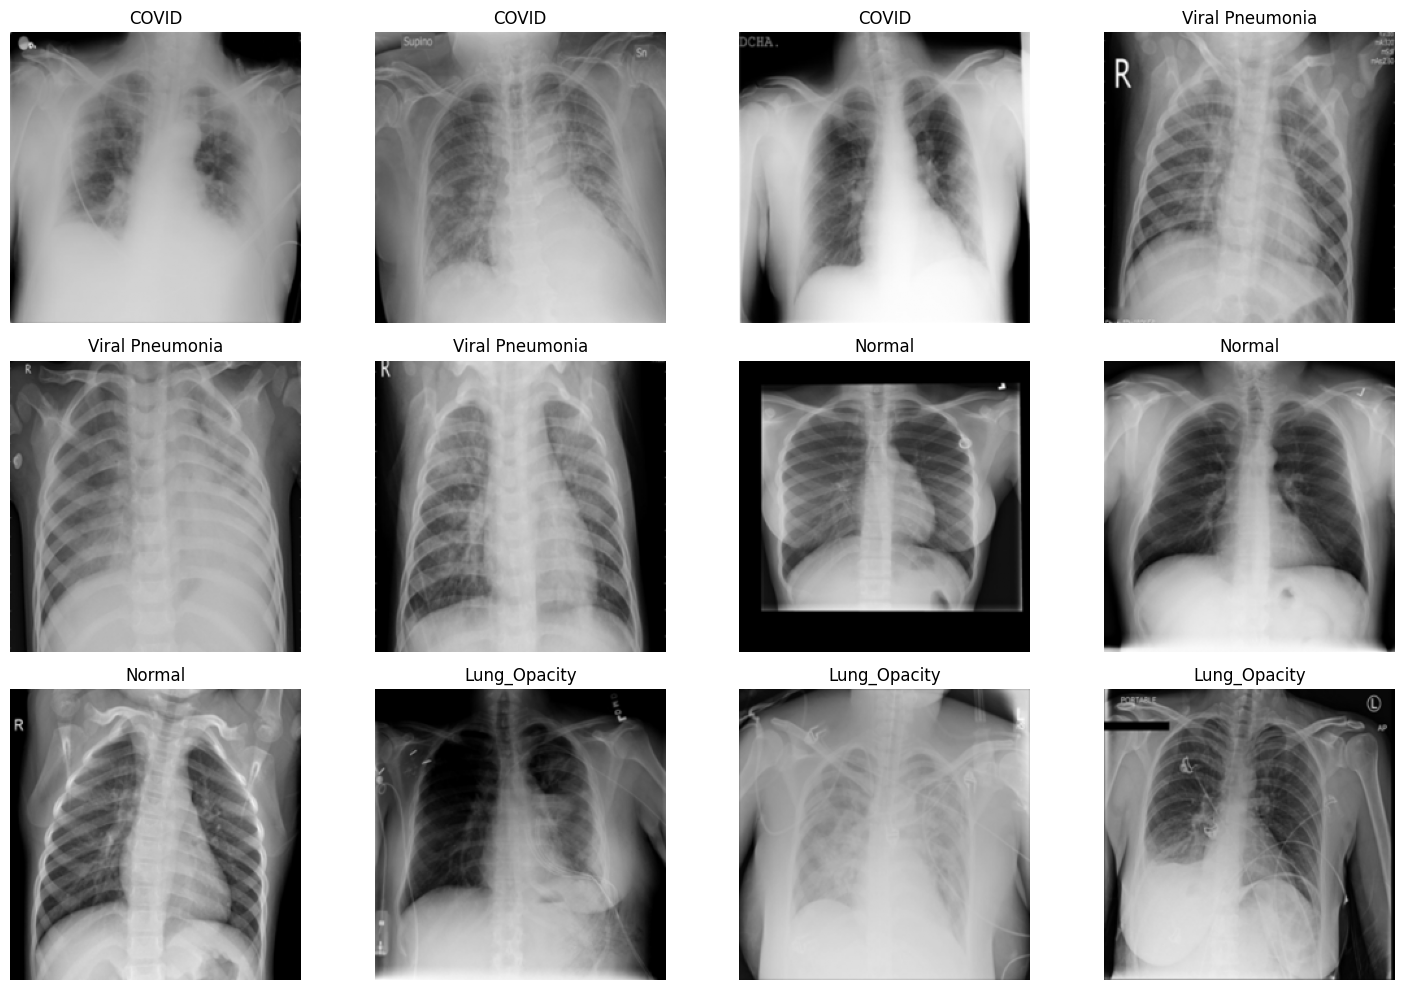

In [3]:
def visualize_sample_images(images, labels, categories):
    if len(images) == 0:
        print("No images to display.")
        return
    
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(categories[labels[i]], fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_sample_images(images, labels, categories)

## 3. Data Preprocessing

### 3.1. Creating Data Generator

In [4]:
# Create data generator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Verify dataset sizes and batch sizes
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Training batch size:", train_generator.batch_size)
print("Validation batch size:", validation_generator.batch_size)

# Calculate steps per epoch
steps_per_epoch_train = train_generator.samples // train_generator.batch_size
steps_per_epoch_val = validation_generator.samples // validation_generator.batch_size

print(f"Steps per epoch (train): {steps_per_epoch_train}")
print(f"Steps per epoch (val): {steps_per_epoch_val}")

# Use .repeat() to ensure the dataset generates enough batches
train_dataset = tf.data.Dataset.from_generator(
    lambda: (x for x in train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )
).repeat().prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: (x for x in validation_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
    )
).repeat().prefetch(tf.data.AUTOTUNE)

Found 33866 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.
Number of training samples: 33866
Number of validation samples: 8464
Training batch size: 32
Validation batch size: 32
Steps per epoch (train): 1058
Steps per epoch (val): 264


## 4. Model Training and Evaluation

### 4.1. MobileNetV2 with L1 and L2 Regularization and Learning Rate Scheduling

In [5]:
def create_mobilenetv2_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    # Unfreeze the last 50 layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True
    
    model = Sequential([
        base_model,
        Flatten(),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.5),
        Dense(4, activation='softmax', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))
    ])
    optimizer = Adam(learning_rate=0.0001)  # Adjusted learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenetv2_model = create_mobilenetv2_model()

# Learning rate schedule
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mobilenetv2_checkpoint = ModelCheckpoint('best_mobilenetv2_model.keras', monitor='val_loss', save_best_only=True)

history_mobilenetv2 = mobilenetv2_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val,
    callbacks=[early_stopping, mobilenetv2_checkpoint, lr_scheduler]
)

Epoch 1/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1061s 988ms/step - accuracy: 0.6091 - loss: 28.2470 - val_accuracy: 0.6838 - val_loss: 6.3597 - learning_rate: 1.0000e-04
Epoch 2/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 770s 728ms/step - accuracy: 0.7335 - loss: 4.0839 - val_accuracy: 0.7939 - val_loss: 2.1837 - learning_rate: 1.0000e-04
Epoch 3/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 772s 730ms/step - accuracy: 0.7559 - loss: 2.1561 - val_accuracy: 0.8744 - val_loss: 1.4531 - learning_rate: 1.0000e-04
Epoch 4/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 785s 742ms/step - accuracy: 0.7703 - loss: 1.6094 - val_accuracy: 0.8987 - val_loss: 1.0936 - learning_rate: 1.0000e-04
Epoch 5/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 777s 735ms/step - accuracy: 0.7839 - loss: 1.3422 - val_accuracy: 0.8255 - val_loss: 1.1396 - learning_rate: 1.0000e-04
Epoch 6/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 737s 697ms/step - accuracy: 0.7926 - loss: 1.1764 - val_accuracy: 0.8021 - val_loss: 1.0337 - learning_rate: 1.0000e-04
Epoch 7/20
1058/1058 ━━━━━

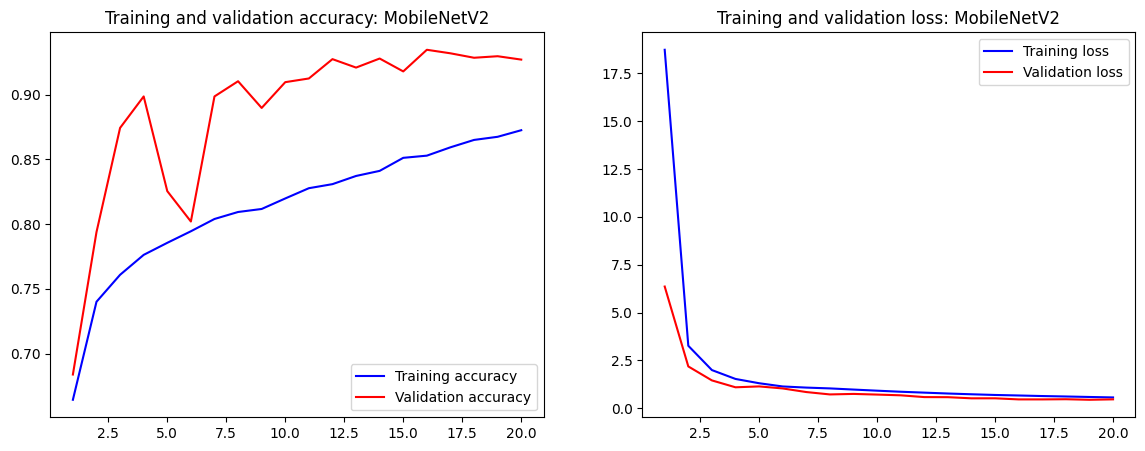

In [6]:
# Function to plot training history 
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history for MobileNetV2
plot_training_history(history_mobilenetv2, 'MobileNetV2')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<Figure size 1000x800 with 0 Axes>

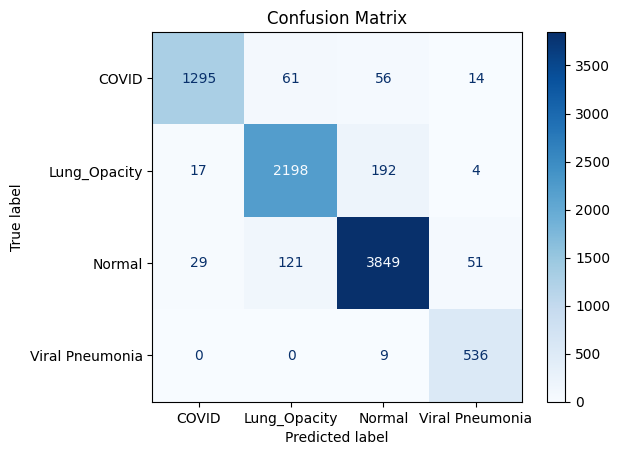

                 precision    recall  f1-score   support

          COVID       0.97      0.91      0.94      1426
   Lung_Opacity       0.92      0.91      0.92      2411
         Normal       0.94      0.95      0.94      4050
Viral Pneumonia       0.89      0.98      0.93       545

       accuracy                           0.93      8432
      macro avg       0.93      0.94      0.93      8432
   weighted avg       0.93      0.93      0.93      8432

Accuracy: 0.9343
Precision: [0.96569724 0.92352941 0.93740867 0.88595041]
Recall: [0.90813464 0.91165491 0.95037037 0.98348624]
Specificity: [0.9934342  0.96977246 0.94135098 0.99125143]
F1-Scores: [0.9360318  0.91755375 0.94384502 0.93217391]


In [7]:
# Function to evaluate the model
def evaluate_model(model, validation_generator, steps):
    y_true = []
    y_pred = []

    for i in range(steps):
        x_val, y_val = next(validation_generator)
        preds = model.predict(x_val)
        y_true.extend(np.argmax(y_val, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=validation_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())
    print(report)

    # Calculate and print metrics
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    specificity = (np.sum(conf_matrix) - np.sum(conf_matrix, axis=0) - np.sum(conf_matrix, axis=1) + np.diag(conf_matrix)) / (np.sum(conf_matrix) - np.sum(conf_matrix, axis=1))
    f1_scores = 2 * (precision * recall) / (precision + recall)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1-Scores: {f1_scores}')

# Evaluate MobileNetV2 model
evaluate_model(mobilenetv2_model, validation_generator, steps_per_epoch_val)

### 4.2 DenseNet121 Model

In [26]:
# Load DenseNet121 model pre-trained on ImageNet
def create_densenet_model():
    base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True
    
    model = Sequential([
        base_model,
        Flatten(),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(4, activation='softmax', kernel_regularizer=l2(0.001))
    ])
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

densenet_model = create_densenet_model()

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_densenet_model.keras', monitor='val_loss', save_best_only=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Training the DenseNet model
history_densenet = densenet_model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=20,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1337s 1s/step - accuracy: 0.6301 - loss: 1.4840 - val_accuracy: 0.8647 - val_loss: 0.6600 - learning_rate: 9.0484e-05
Epoch 2/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1266s 1s/step - accuracy: 0.7337 - loss: 0.9238 - val_accuracy: 0.8678 - val_loss: 0.6001 - learning_rate: 8.1873e-05
Epoch 3/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1291s 1s/step - accuracy: 0.7520 - loss: 0.8599 - val_accuracy: 0.8907 - val_loss: 0.5240 - learning_rate: 7.4082e-05
Epoch 4/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1474s 1s/step - accuracy: 0.7706 - loss: 0.7938 - val_accuracy: 0.8987 - val_loss: 0.4983 - learning_rate: 6.7032e-05
Epoch 5/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1262s 1s/step - accuracy: 0.7794 - loss: 0.7612 - val_accuracy: 0.8982 - val_loss: 0.4833 - learning_rate: 6.0653e-05
Epoch 6/20
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 1248s 1s/step - accuracy: 0.7844 - loss: 0.7365 - val_accuracy: 0.8991 - val_loss: 0.4709 - learning_rate: 5.4881e-05
Epoch 7/20
1058/1058 ━━━━━━━━━━━━━━━━━━━

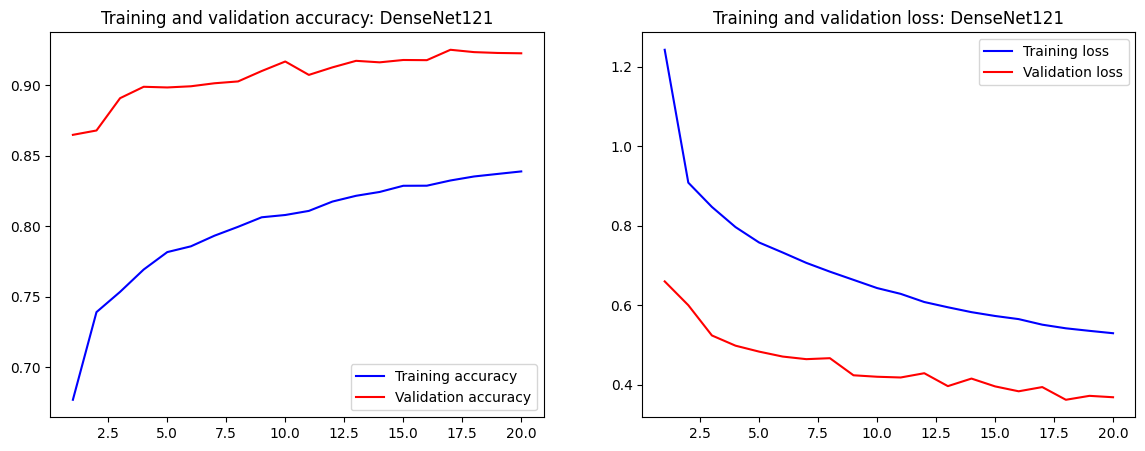

In [29]:
# Function to plot training history 
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history for DenseNet121
plot_training_history(history_densenet, 'DenseNet121')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

<Figure size 1000x800 with 0 Axes>

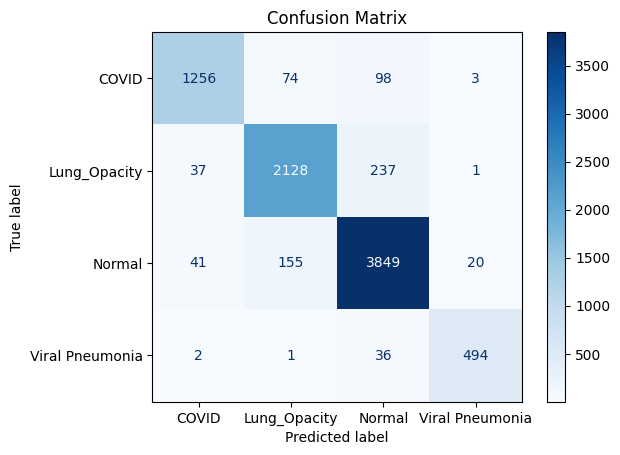

                 precision    recall  f1-score   support

          COVID       0.94      0.88      0.91      1431
   Lung_Opacity       0.90      0.89      0.89      2403
         Normal       0.91      0.95      0.93      4065
Viral Pneumonia       0.95      0.93      0.94       533

       accuracy                           0.92      8432
      macro avg       0.93      0.91      0.92      8432
   weighted avg       0.92      0.92      0.92      8432

Accuracy: 0.9164
Precision: [0.94011976 0.90245971 0.91208531 0.95366795]
Recall: [0.8777079  0.88555972 0.94686347 0.92682927]
Specificity: [0.98857306 0.96185105 0.91504465 0.99696164]
F1-Scores: [0.90784243 0.89392985 0.92914906 0.94005709]


In [31]:
# Function to evaluate the model
def evaluate_model(model, validation_generator, steps):
    y_true = []
    y_pred = []

    for i in range(steps):
        x_val, y_val = next(validation_generator)
        preds = model.predict(x_val)
        y_true.extend(np.argmax(y_val, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=validation_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())
    print(report)

    # Calculate and print metrics
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    specificity = (np.sum(conf_matrix) - np.sum(conf_matrix, axis=0) - np.sum(conf_matrix, axis=1) + np.diag(conf_matrix)) / (np.sum(conf_matrix) - np.sum(conf_matrix, axis=1))
    f1_scores = 2 * (precision * recall) / (precision + recall)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1-Scores: {f1_scores}')

# Evaluate DenseNet121 model
evaluate_model(densenet_model, validation_generator, steps_per_epoch_val)